# 创建 `Collect` 环境包装器

In [1]:
import logging
import sys
from pathlib import Path
from d2py.utils.log_config import config_logging

root_dir = Path(".").resolve()
sys.path.extend([str(root_dir.parents[3]/"tests/gym-multigrid")])
temp_dir = root_dir/"images"
temp_dir.mkdir(parents=True, exist_ok=True)
logger_name = "gym_multigrid"
logger = logging.getLogger(logger_name)
config_logging(f'{temp_dir}/{logger_name}.log', logger_name, maxBytes=50000, backupCount=2)

In [2]:
from pathlib import Path
import imageio
from gym_multigrid.envs.collect_game import CollectGameEnv

kwargs={
    "size": 15,
    "num_balls": [5,],
    "agents_index": [1, 2, 3],  # green, purple
    "balls_index": [0,],  # red, orange, yellow
    "balls_reward": [1,],
    "respawn": False,
}
origin_env = CollectGameEnv(**kwargs)
frames = [origin_env.render()]
obs, info = origin_env.reset()
while True:
    actions = [origin_env.action_space.sample() for a in origin_env.agents]
    obs, reward, terminated, truncated, info = origin_env.step(actions)
    frames.append(origin_env.render())
    if terminated or truncated:
        logger.info(f"episode ended after {origin_env.step_count} steps")
        logger.info(f"agents collected {origin_env.collected_balls} objects")
        break
temp_dir = Path(temp_dir)
(temp_dir/"animations").mkdir(parents=True, exist_ok=True)
imageio.mimsave(temp_dir/f"animations/multigrid-collect.gif", frames, duration=0.5)

INFO|2024-10-28 23:50:30,475|gym_multigrid| >>> episode ended after 100 steps
INFO|2024-10-28 23:50:30,477|gym_multigrid| >>> agents collected 3 objects


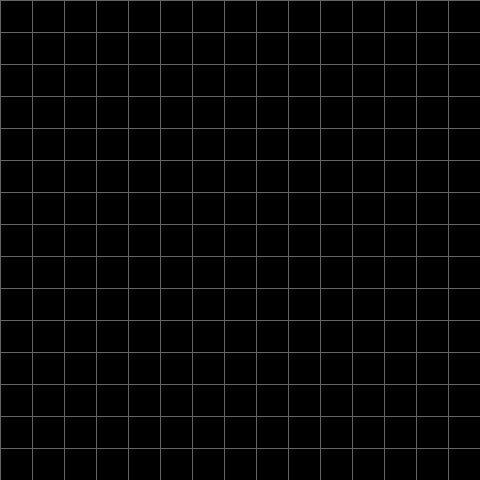

In [3]:
from IPython import display
display.Image(temp_dir/f"animations/multigrid-collect.gif")

创建初始环境：

In [31]:
from dataclasses import dataclass
from typing import Any, SupportsFloat
import gymnasium as gym
from gymnasium import Wrapper, Env
from gymnasium.core import WrapperActType, WrapperObsType, RenderFrame, ObsType, ActType
from gym_multigrid.core.constants import TILE_PIXELS

@dataclass
class RewardWrapper(Wrapper):
    env: Env[ObsType, ActType]
    logger_name: str # 日志名称

    def __post_init__(self):
        # self.metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
        self.logger = logging.getLogger(self.logger_name)
        self.obs_shape = self.env.observation_space.shape
        self.agents = self.env.agents

    # def render(self, close=False, highlight=False, tile_size=TILE_PIXELS) -> RenderFrame | list[RenderFrame] | None:
    #     return self.env.render(close=close, highlight=highlight, tile_size=tile_size)

    def step(
        self, action: WrapperActType
    ) -> tuple[WrapperObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.logger.info(f"obs, reward, terminated, truncated, info: {obs, reward, terminated, truncated, info}")
        return obs, reward, terminated, truncated, info


In [32]:
env = RewardWrapper(origin_env, logger_name)
frames = [env.render()]
obs, info = env.reset()
while True:
    actions = [env.action_space.sample() for a in env.agents]
    obs, reward, terminated, truncated, info = env.step(actions)
    frames.append(env.render())
    if terminated or truncated:
        logger.info(f"episode ended after {env.step_count} steps")
        logger.info(f"agents collected {env.collected_balls} objects")
        break

AttributeError: 'RewardWrapper' object has no attribute '_action_space'

In [26]:
env.obs_shape

(15, 15, 3)